In [1]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test

from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.environment import _resize_array
from viz import plot_trajectory_in_tank

from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from datetime import datetime

import pandas as pd
import numpy as np
import h5py
import os

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

## Parameters

In [3]:
agent_speed = 4 # Walking speed cm/s
dt = 0.4 # s (walking for an average of 0.4s)
stop_dt = 1.3 # s (average stop time)
step_dt = dt + stop_dt
step_dist = agent_speed * dt # cm

max_time = 900 # s (Experiments topped after 15mins)
max_steps = int(max_time / step_dt)

multiplier = agent_speed * dt
actual_tank_size = np.array([90,114]) # actual size: 90cm x 114cm but it is scaled by a walking speed of <multiplier>
tank_size = (actual_tank_size / multiplier).astype(int)
space_shape = (tank_size * 2) + 1

source_position = tank_size

goal_radius = 1
# odor_radius = 10.5
odor_radius = 3 / multiplier # 3 cm * 0.8 -> 3.75 grid units

print(f'Tank size: {tank_size.tolist()}; Space shape {space_shape.tolist()}; States count: {space_shape.prod()}')

Tank size: [56, 71]; Space shape [113, 143]; States count: 16159


In [4]:
# Odor variables
thresh_scale = 5
thresh = 3 / 10**(thresh_scale)

base_odor_plume_file = f'../plume_average_computation/average_odor_base_3e{thresh_scale}.npy'
odor_fields_folder = '/storage/arnaud/tank_odor_field_2024_06_13/'
test_result_folder = f'./results-thresh_3e{thresh_scale}-{datetime.now().strftime("%Y%m%d_%H%M%S")}/'

## Building POMDP Model

In [5]:
# Legs odor field
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

In [6]:
# Gathering nose odor plume
average_odor_plume = np.load(base_odor_plume_file)

odor_shape = np.array([408, 488])
odor_center = np.array([500, 500])

lower_bound = odor_center - (odor_shape / 2).astype(int)
upper_bound = odor_center + (odor_shape / 2).astype(int)
slices = [slice(lb, ub) for lb, ub in zip(lower_bound, upper_bound)]

average_odor_plume = average_odor_plume[*slices]

assert all(average_odor_plume.shape == odor_shape)

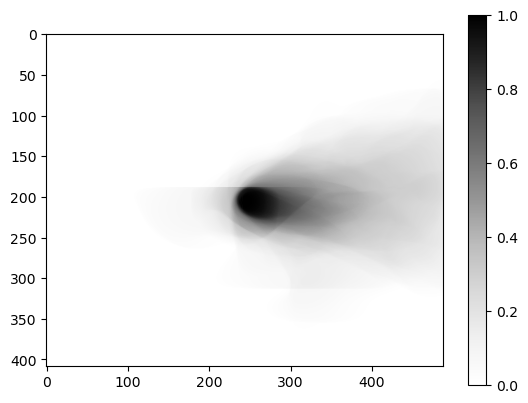

In [7]:
plt.imshow(average_odor_plume, cmap='Greys')
plt.colorbar()
plt.show()

In [8]:
# Nose odor field
tank_average_odor_plume = _resize_array(average_odor_plume, tank_size, 'linear')

# Putting odor plume average in
nose_odor_field = np.zeros(odor_field.shape)
lower_bounds, upper_bounds = (tank_size/2).astype(int), (tank_size/2).astype(int) + tank_size
nose_odor_field[*[slice(lb, ub) for lb, ub in zip(lower_bounds, upper_bounds)]] = tank_average_odor_plume

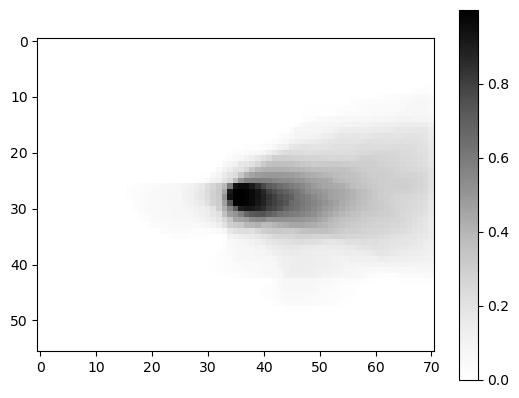

In [9]:
plt.imshow(tank_average_odor_plume, cmap='Greys')
plt.colorbar()
plt.show()

In [ ]:
from scipy.optimize import curve_fit

# Define the 2D double exponential function
def double_exponential(xy, A, x0, y0, sigma_x, sigma_y):
    x, y = xy
    return A * np.exp(-np.abs(x - x0) / sigma_x) * np.exp(-np.abs(y - y0) / sigma_y)

# Create meshgrid for fitting
x = np.arange(tank_average_odor_plume.shape[1])
y = np.arange(tank_average_odor_plume.shape[0])
x, y = np.meshgrid(x, y)

# Flatten the arrays for curve fitting
x_data = x.ravel()
y_data = y.ravel()
z_data = tank_average_odor_plume.ravel()

# Initial guess for the parameters
initial_guess = [1, tank_size[1] // 2, tank_size[0] // 2, 10, 10]

# Fit the double exponential function to the data
params, _ = curve_fit(double_exponential, (x_data, y_data), z_data, p0=initial_guess)

# Generate fitted data
fitted_data = double_exponential((x, y), *params).reshape(tank_average_odor_plume.shape)

# Plot the original data and the fitted data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(tank_average_odor_plume, cmap='Greys')
ax[0].set_title('Original Data')
ax[0].colorbar()

ax[1].imshow(fitted_data, cmap='Greys')
ax[1].set_title('Fitted 2D Double Exponential')
ax[1].colorbar()

plt.show()

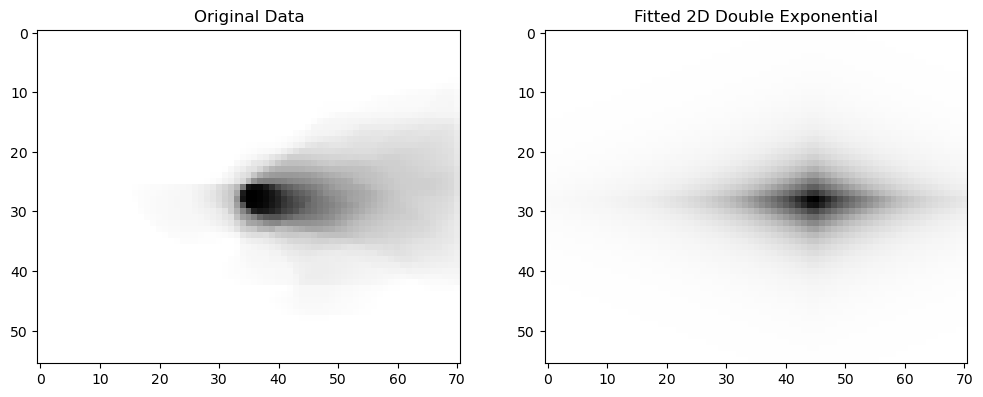

In [20]:
from scipy.optimize import curve_fit

# Define the 2D double exponential function
def double_exponential(xy, A, x0, y0, sigma_x, sigma_y):
    x, y = xy
    return A * np.exp(-np.abs(x - x0) / sigma_x) * np.exp(-np.abs(y - y0) / sigma_y)

# Create meshgrid for fitting
x = np.arange(tank_average_odor_plume.shape[1])
y = np.arange(tank_average_odor_plume.shape[0])
x, y = np.meshgrid(x, y)

# Flatten the arrays for curve fitting
x_data = x.ravel()
y_data = y.ravel()
z_data = tank_average_odor_plume.ravel()

# Initial guess for the parameters
initial_guess = [1, tank_size[1] // 2, tank_size[0] // 2, 10, 10]

# Fit the double exponential function to the data
params, _ = curve_fit(double_exponential, (x_data, y_data), z_data, p0=initial_guess)

# Generate fitted data
fitted_data = double_exponential((x, y), *params).reshape(tank_average_odor_plume.shape)

# Plot the original data and the fitted data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(tank_average_odor_plume, cmap='Greys')
ax[0].set_title('Original Data')
# ax[0].colorbar()

ax[1].imshow(fitted_data, cmap='Greys')
ax[1].set_title('Fitted 2D Double Exponential')
# ax[1].colorbar()

plt.show()

In [10]:
thresholds = np.array([-np.inf,1,2,np.inf])
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

In [11]:
# Base Model parameters
state_count = np.prod(space_shape)

state_grid = [[f's_{x}_{y}' for x in range(space_shape[1])] for y in range(space_shape[0])]
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source_position[0])**2 + (y-source_position[1])**2) <= goal_radius**2,
                                            shape=space_shape).ravel())[:,0].tolist()

# Counts
action_count = len(action_set)
observation_count = thresholds.shape[-1] # Thresholds minus 1; plus 1 for the goal.

# Building observation matrix
observations = np.empty((state_count, action_count, observation_count), dtype=float)

filt_nose_odor_field = nose_odor_field.ravel()
filt_nose_odor_field[odor_field.ravel() > 0.0] = 0.0

observations[:,:,1] = filt_nose_odor_field[:,None] # Nose
observations[:,:,2] = odor_field.ravel()[:,None] # Nose AND legs
observations[:,:,0] = 1.0 - observations[:,:,1] - observations[:,:,2] # Nothing

# Goal observation
observations[:,:,-1] = 0.0
observations[end_states,:,:] = 0.0
observations[end_states,:,-1] = 1.0

# Assert observations sum to 1
assert np.all(np.sum(observations, axis=2) == 1.0), "Observation table malformed, something is wrong..."

# Observation labels
observation_labels = ['nothing', 'something_nose', 'something_nose_legs', 'goal']

# Compute reachable states
points = np.array(np.unravel_index(np.arange(np.prod(space_shape)), space_shape)).T

# For each actions compute all new grid points (using the environment.move method)
action_new_states = []
movements = action_set
for move_vector in movements:

    # Applying the movement vector
    new_points = points + move_vector

    # Wrap points
    new_points = np.where(new_points < 0, (new_points + space_shape[None,:]), new_points)
    new_points = np.where(new_points >= space_shape[None,:], (new_points - space_shape[None,:]), new_points)

    new_states = np.ravel_multi_index((new_points[:,0], new_points[:,1]), dims=space_shape)
    action_new_states.append(new_states)

# Forming it the reachable states array from the new states for each action
reachable_states = np.array(action_new_states).T[:,:,None]

# Instantiate the model object
model = Model(
    states = state_grid,
    actions = action_labels,
    observations = observation_labels,
    reachable_states = reachable_states,
    observation_table = observations,
    end_states = end_states
)

## Building Environment

In [12]:
odor_field_files = os.listdir(odor_fields_folder)
odor_field_environments = []
odor_field_source_pos = []

for file_i, file in enumerate(odor_field_files):
    print(f'[{file_i+1}/{len(odor_field_files)}] Loading odor field: {odor_fields_folder}{file}')

    # Loading data
    data = h5py.File(odor_fields_folder + file, 'r')

    # Finding out start and end times
    time_slices = data['odor_base']
    time_slices = sorted([int(key_name) for key_name in time_slices.keys()])

    start_time = min(time_slices)
    end_time = max(time_slices)

    # Gathering data
    odor = data['odor_base']
    odor_data = [odor[str(time)] for time in range(start_time, end_time)]
    odor_data_array = np.array(odor_data)

    # Resizing the data array
    new_odor_data_array = np.zeros((len(odor_data_array), *tank_size))
    for i, data_slice in enumerate(odor_data_array):
        new_odor_data_array[i] = _resize_array(data_slice,
                                               new_shape=tank_size,
                                               interpolation='linear')

    # Interpolating the data array to have slices every 1.7 seconds
    time_indices = np.arange(0, len(odor_data_array), 1.7)
    interpolated_odor_data_array = np.zeros((len(time_indices), *tank_size))
    for i in range(tank_size[0]):
        for j in range(tank_size[1]):
            interpolated_odor_data_array[:, i, j] = np.interp(time_indices, np.arange(len(odor_data_array)), new_odor_data_array[:, i, j])
    new_odor_data_array = interpolated_odor_data_array

    # compute the odor source position
    source_pos = np.unravel_index(np.argmax(new_odor_data_array[0]), shape=new_odor_data_array[0].shape)

    # Centering the odor field
    centered_odor_data_array = np.zeros((len(new_odor_data_array), *space_shape))
    for i, data_slice in enumerate(new_odor_data_array):
        centered_odor_data_array[i,
                                (tank_size[0] - source_pos[0]) : (tank_size[0] - source_pos[0] + tank_size[0]),
                                (tank_size[1] - source_pos[1]) : (tank_size[1] - source_pos[1] + tank_size[1])] = data_slice

    # Filtering the odor field
    filt_odor_data_array = (centered_odor_data_array > thresh).astype(float)

    legs_odor = np.argwhere(odor_field > 0)
    for i in range(len(filt_odor_data_array)):
        filt_odor_data_array[i,*legs_odor.T] = 2.0

    # Trimming the odor data array to stop at the "max_time" amount
    filt_odor_data_array = filt_odor_data_array[:max_steps]

    # Setting up environment
    env = Environment(data_file = filt_odor_data_array,
                      data_source_position = tank_size,
                      source_radius = goal_radius,
                      boundary_condition = 'wrap')

    # Saving environment and source positions
    odor_field_environments.append(env)
    odor_field_source_pos.append(np.array(source_pos) / np.array(new_odor_data_array.shape[1:]))

[1/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/35_75.h5
[2/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/65_75.h5
[3/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/35_35.h5
[4/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/45_5.h5
[5/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/45_35.h5
[6/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/25_65.h5
[7/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/55_45.h5
[8/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/20_65.h5
[9/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/25_55.h5
[10/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/15_45.h5
[11/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/15_5.h5
[12/12] Loading odor field: /storage/arnaud/tank_odor_field_2024_06_13/55_25.h5


## Agent Training

In [13]:
ag = FSVI_Agent(odor_field_environments[0],
                model=model,
                thresholds=[-np.inf, 1.0, 2.0, np.inf])

In [14]:
_ = ag.train(expansions=800,
             max_belief_growth=100,
             eps=1e-8,
             use_gpu=True)

[01/10/2025, 13:56:35] MDP_policy, not provided. Solving MDP with Value Iteration...
[01/10/2025, 13:56:35] Sending Model to GPU...
[01/10/2025, 13:56:35]     > Done in 0.196s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 16159-state, 4-action
  - Converged in 1000 iterations and 0.8783 seconds
  - Took on average 0.0009s per iteration


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Memory full: Out of memory allocating 23,798,458,368 bytes (allocated so far: 75,100,208,640 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 16159 state, 4 action, 4 observations
  - Converged or stopped after 387 expansion steps and 386 backup steps.
  - Resulting value function has 11506 alpha vectors.
  - Converged in 276.6861s

  - Expand function took on average 0.0755s and yielded on average 7397.32 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 0.6411s and yielded on average 29.80 alpha vectors per iteration. (0.0002s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


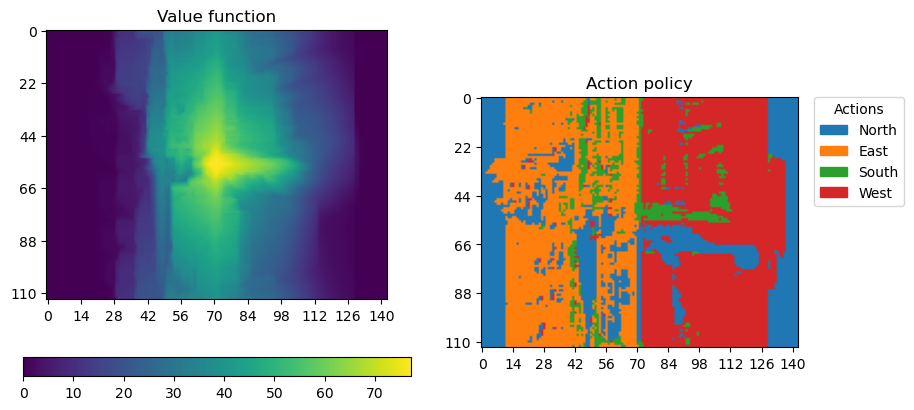

In [15]:
ag.value_function.plot()

## Run test

### Single point

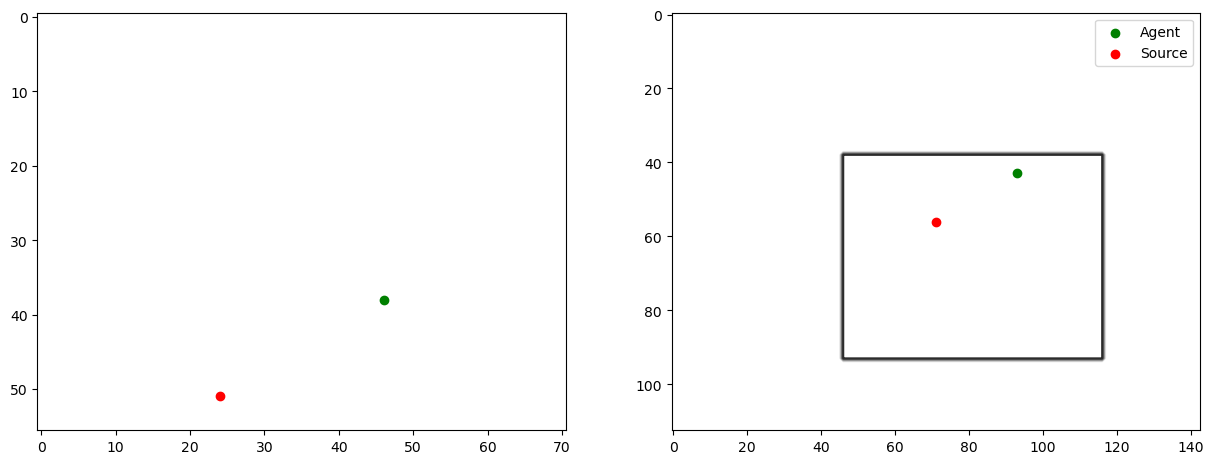

In [16]:
# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(space_shape)
belief[center_state[0]:center_state[0]+tank_size[0], center_state[1]:center_state[1]+tank_size[1]] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(space_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [17]:
belief = BeliefSet(model=ag.model, beliefs=[Belief(model=ag.model, values=belief.ravel())])
hist = run_test(agent=ag,
                start_points=agent_start_state[None,:],
                horizon=max_steps,
                initialization_values={'belief': belief},
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

Simulations done in 1.020s:
Simulations reached goal: 1/1 (0 failures (reached horizon: 0)) (100.00% success)
 - Average step count:                 244.000 +- 0.00 (Successful only: 244.000 +- nan)
 - Extra steps:                        210.000 +- 0.00 (Successful only: 210.000 +- nan)
 - Average discounted rewards (ADR):   0.086 +- 0.00 (Successful only: 0.086 +- nan)
 - Tmin/T:                             0.139 +- 0.00 (Successful only: 0.139 +- nan)


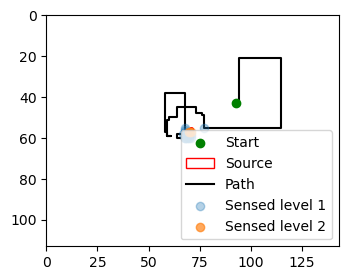

In [18]:
hist.plot()

### Experimental data

In [19]:
df = pd.read_csv('../experimental_data/experimental_positions.csv')

In [20]:
exp_source_indices = df[['y_food_cm','x_food_cm']].to_numpy().astype(float)
exp_agent_indices = df[['y0_cm', 'x0_cm']].to_numpy().astype(float)

exp_source_indices /= multiplier
exp_agent_indices /= multiplier

exp_source_indices = exp_source_indices.astype(int)
exp_agent_indices = exp_agent_indices.astype(int)

In [21]:
source_distances = []
odor_field_source_positions_in_tank = np.array(odor_field_source_pos) * tank_size

for source_pos in odor_field_source_positions_in_tank:
    source_distances.append(np.sum((exp_source_indices - source_pos) ** 2, axis=1) ** (1/2))

assigned_environment = np.argmin(np.array(source_distances), axis=0)

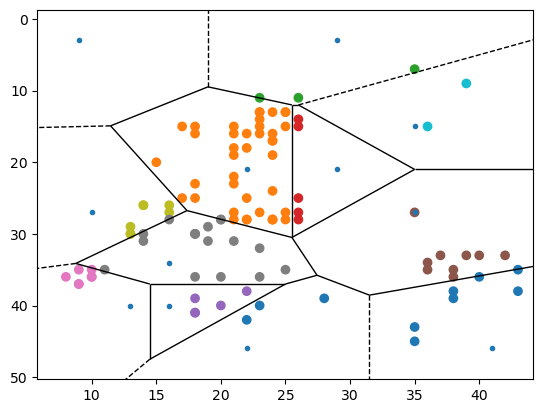

In [22]:
vor = Voronoi(odor_field_source_positions_in_tank[:,::-1])
fig = voronoi_plot_2d(vor, show_vertices=False)

plt.scatter(exp_source_indices[:,1], exp_source_indices[:,0], c=assigned_environment, cmap='tab10')
plt.gca().invert_yaxis()
plt.show()

In [23]:
# Generation of points
n = len(exp_source_indices)

# STATE SPACE
center_state = exp_agent_indices
agent_start_state = center_state + (tank_size[None,:] - exp_source_indices)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0], center[1]:center[1]+tank_size[1]] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [24]:
all_hist = None

source_ids = np.arange(len(exp_source_indices))
new_order_source_ids = []

for source_i, source_pos in enumerate(odor_field_source_positions_in_tank):
    print(f'[{source_i+1}/{len(odor_field_source_positions_in_tank)}] Environment {source_i}')

    # Checking which experimental source points have been assigned to the current environment
    is_assigned_model = (assigned_environment == source_i)
    env = odor_field_environments[source_i]
    new_order_source_ids += source_ids[is_assigned_model].tolist()

    # Skip if no experimental source point is assigned to the environment
    if np.sum(is_assigned_model) == 0:
        continue

    belief = BeliefSet(ag.model, beliefs[is_assigned_model])
    hist = run_test(agent=ag,
                    start_points=agent_start_state[is_assigned_model],
                    environment=env,
                    horizon=max_steps,
                    initialization_values={'belief': belief},
                    use_gpu=True,
                    print_stats=False)

    # Combine the history to the previous history instance
    if all_hist is None:
        all_hist = hist
    else:
        all_hist += hist

[1/12] Environment 0
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[2/12] Environment 1
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[3/12] Environment 2
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[4/12] Environment 3
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[5/12] Environment 4
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[6/12] Environment 5
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[7/12] Environment 6
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[8/12] Environment 7
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[9/12] Environment 8
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[10/12] Environment 9
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

[11/12] Environment 10
[12/12] Environment 11
Using the provided environment, not the agent environment.
Using the provided environment, not the agent environment.


  0%|          | 0/529 [00:00<?, ?it/s]

In [25]:
print(all_hist.summary)

Simulations reached goal: 95/116 (21 failures (reached horizon: 20)) (81.90% success)
 - Average step count:                 324.655 +- 151.12 (Successful only: 279.579 +- 129.76)
 - Extra steps:                        286.759 +- 153.32 (Successful only: 241.695 +- 132.72)
 - Average discounted rewards (ADR):   0.116 +- 0.19 (Successful only: 0.140 +- 0.20)
 - Tmin/T:                             0.198 +- 0.23 (Successful only: 0.226 +- 0.24)


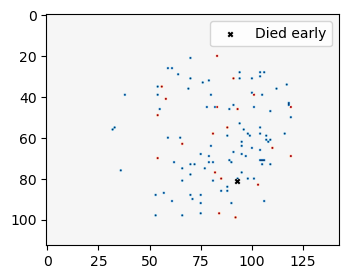

In [26]:
all_hist.plot_successes()

In [27]:
if not os.path.isdir(test_result_folder):
    os.mkdir(test_result_folder)

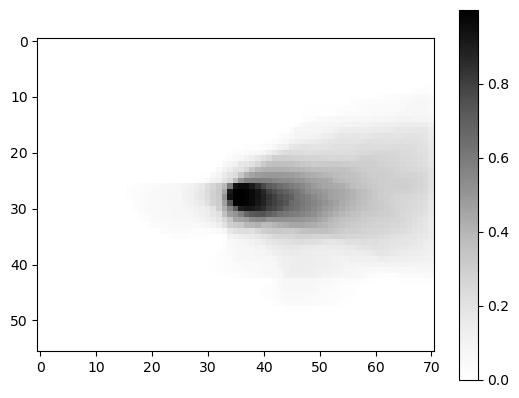

In [28]:
plt.imshow(tank_average_odor_plume, cmap='Greys')
plt.colorbar()
plt.savefig(test_result_folder + 'plume.png')

In [29]:
all_hist.save(folder=test_result_folder)

Simulations saved to: ./results-thresh_3e5-20250110_135618/Simulations-s_113_143-n_116-20250110_140337-horizon_529.csv
Simulation's analysis saved to: ./results-thresh_3e5-20250110_135618/Simulations-s_113_143-n_116-20250110_140337-horizon_529-analysis.csv


### Results

In [30]:
# Re-ordering source and agent positions
new_order_exp_agent_indices = exp_agent_indices[new_order_source_ids]
new_order_exp_source_indices = exp_source_indices[new_order_source_ids]
new_order_assigned_environment = assigned_environment[new_order_source_ids]
assigned_environment_file = [(odor_fields_folder + odor_field_files[env_i]) for env_i in new_order_assigned_environment]

In [31]:
# Computing the amount of steps out of bounds
list_steps_out_of_bounds = []

for traj in range(len(new_order_exp_agent_indices)):
    # Retrieving sim
    sim = all_hist.simulation_dfs[traj]

    # Compute shift
    start_coord = sim[['y', 'x']].to_numpy()[0]
    shift = start_coord - new_order_exp_agent_indices[traj]

    # Retrieving sequence
    seq = sim[['y','x']].to_numpy() - shift[None,:]

    # Computing steps out of bounds
    steps_out_of_bounds = np.sum(np.any((seq < 0) | (seq >= tank_size), axis=1))

    # Compute the bounds for 5% and 10% of tank_size
    bounds_5_percent = tank_size * 0.05
    bounds_10_percent = tank_size * 0.10
    bounds_25_percent = tank_size * 0.25

    # Compute steps out of bounds by 5% and 10% using Manhattan distance
    steps_out_of_bounds_5_percent = np.sum(np.any((seq < -bounds_5_percent) | (seq >= tank_size + bounds_5_percent), axis=1))
    steps_out_of_bounds_10_percent = np.sum(np.any((seq < -bounds_10_percent) | (seq >= tank_size + bounds_10_percent), axis=1))
    steps_out_of_bounds_25_percent = np.sum(np.any((seq < -bounds_25_percent) | (seq >= tank_size + bounds_25_percent), axis=1))

    # Append the results to the list
    list_steps_out_of_bounds.append([steps_out_of_bounds, steps_out_of_bounds_5_percent, steps_out_of_bounds_10_percent, steps_out_of_bounds_25_percent])

array_steps_out_of_bounds = np.array(list_steps_out_of_bounds)
out_of_bounds_amount = np.sum(array_steps_out_of_bounds > 0, axis=1)

count_out_of_bounds = len(np.argwhere(array_steps_out_of_bounds[:,0]))

print(f'Simulations with steps out of bounds: {count_out_of_bounds} / {len(array_steps_out_of_bounds[:,0])}' + ('' if count_out_of_bounds == 0 else f' (avg length {np.mean(array_steps_out_of_bounds[array_steps_out_of_bounds[:,0] > 0, 0]):.2f})'))
tot = 0
for i, bound in enumerate([0, 5, 10, 25]):
    count = np.sum(out_of_bounds_amount == i)
    tot += count
    print(f'   - Inside {bound}%: {tot}')

Simulations with steps out of bounds: 62 / 116 (avg length 76.13)
   - Inside 0%: 54
   - Inside 5%: 71
   - Inside 10%: 81
   - Inside 25%: 84


In [32]:
res_sim_df = all_hist.analysis_df

res_sim_df['steps_in_05perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,0].tolist()
res_sim_df['steps_in_10perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,1].tolist()
res_sim_df['steps_in_25perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,2].tolist()
res_sim_df['steps_out_25perc_marg'] = [None]*4 + array_steps_out_of_bounds[:,3].tolist()

# 0: no out of bounds, 1: < 5% out of bounds, 2: < 10% out of bounds, 3: < 25% out of bounds, 4: > 25% out of bounds
res_sim_df['tank_leaving_amount'] = [None]*4 + out_of_bounds_amount.tolist()

# Adding agent and source position info to result dataframe
res_sim_df['y_source_cm'] = [None]*4 + (new_order_exp_source_indices[:,0] * multiplier).tolist()
res_sim_df['x_source_cm'] = [None]*4 + (new_order_exp_source_indices[:,1] * multiplier).tolist()
res_sim_df['y_agent_cm'] = [None]*4 + (new_order_exp_agent_indices[:,0] * multiplier).tolist()
res_sim_df['x_agent_cm'] = [None]*4 + (new_order_exp_agent_indices[:,1] * multiplier).tolist()
res_sim_df['odor_field_file'] = [None]*4 + assigned_environment_file

res_sim_df = res_sim_df.drop(columns=['discounted_rewards'])

res_sim_df

,y,x,optimal_steps_count,converged,reached_horizon,steps_taken,extra_steps,t_min_over_t,steps_in_05perc_marg,steps_in_10perc_marg,steps_in_25perc_marg,steps_out_25perc_marg,tank_leaving_amount,y_source_cm,x_source_cm,y_agent_cm,x_agent_cm,odor_field_file
mean,NaN,NaN,NaN,0.818966,0.172414,324.655172,286.758621,0.198397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
standard_deviation,NaN,NaN,NaN,0.385047,0.37774,151.115114,153.317657,0.226854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
success_mean,NaN,NaN,NaN,1.0,0.0,279.578947,241.694737,0.226378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
success_standard_deviation,NaN,NaN,NaN,0.0,0.0,129.755382,132.717671,0.242777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
run_0,64.0,80.0,16.0,True,False,294.000000,278.000000,0.054422,0.0,0.0,0.0,0.0,0.0,64.0,36.8,76.8,51.2,/storage/arnaud/tank_odor_field_2024_06_13/35_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_111,66.0,104.0,42.0,True,False,404.000000,362.000000,0.103960,72.0,0.0,0.0,0.0,1.0,48.0,20.8,64.0,73.6,/storage/arnaud/tank_odor_field_2024_06_13/15_...
run_112,49.0,54.0,23.0,False,True,529.000000,506.000000,0.043478,151.0,54.0,46.0,29.0,4.0,24.0,57.6,12.8,30.4,/storage/arnaud/tank_odor_field_2024_06_13/55_...
run_113,88.0,75.0,35.0,True,False,277.000000,242.000000,0.126354,10.0,0.0,0.0,0.0,1.0,14.4,62.4,65.6,68.8,/storage/arnaud/tank_odor_field_2024_06_13/55_...
run_114,91.0,61.0,44.0,True,False,182.000000,138.000000,0.241758,0.0,0.0,0.0,0.0,0.0,12.8,78.4,68.8,62.4,/storage/arnaud/tank_odor_field_2024_06_13/55_...


In [33]:
res_sim_df.to_csv(test_result_folder + f'results_{all_hist.start_time.strftime("%Y%m%d_%H%M%S")}.csv')

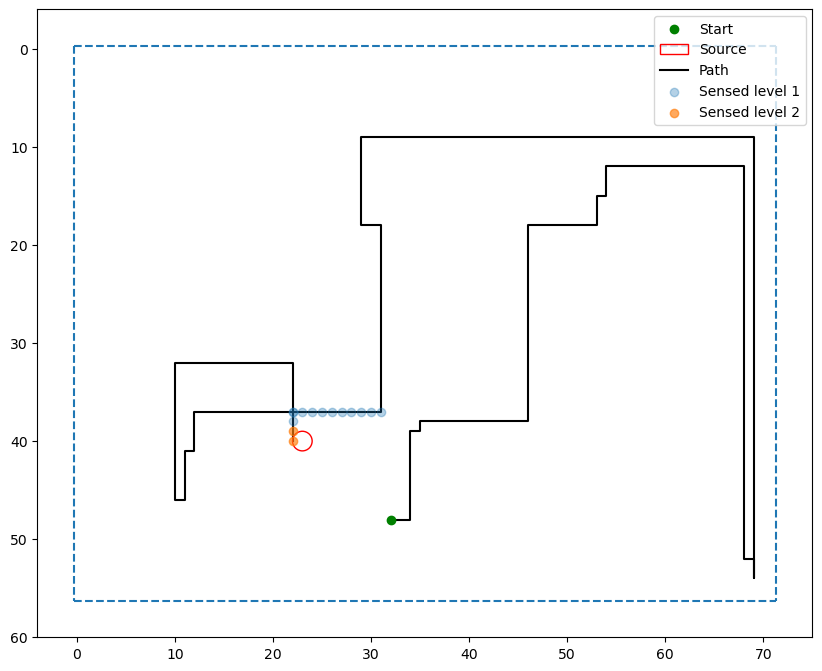

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 0,
                        ax = ax)

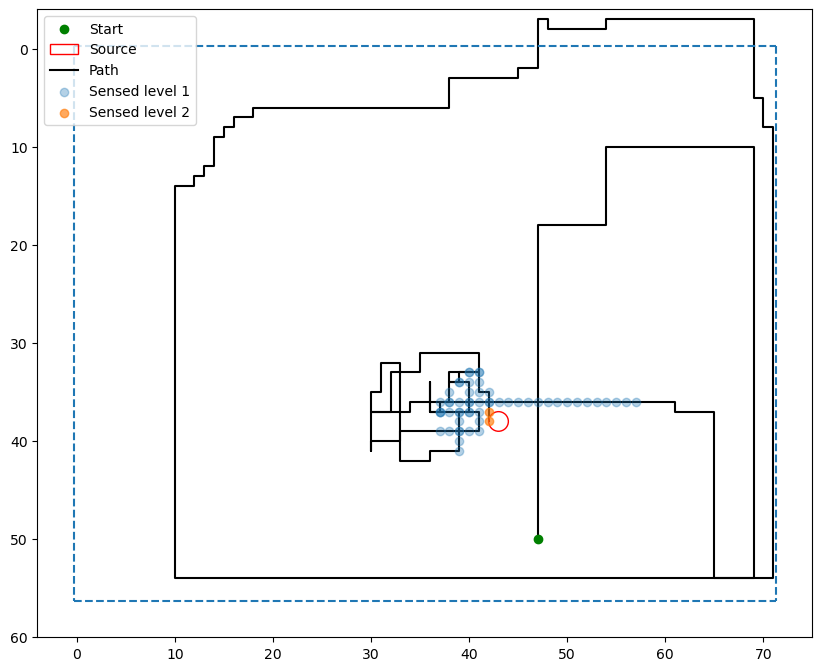

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 10,
                        ax = ax)

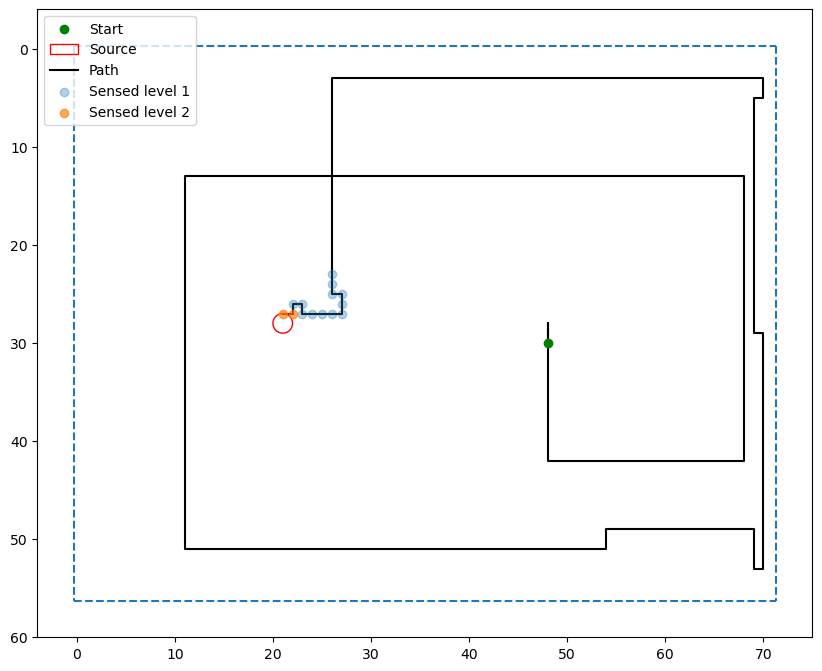

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 20,
                        ax = ax)

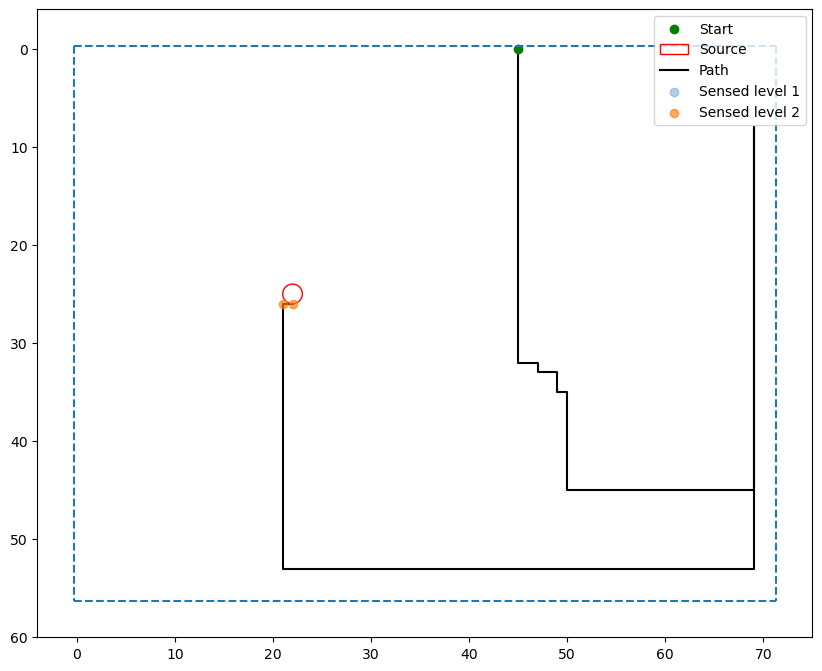

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 30,
                        ax = ax)

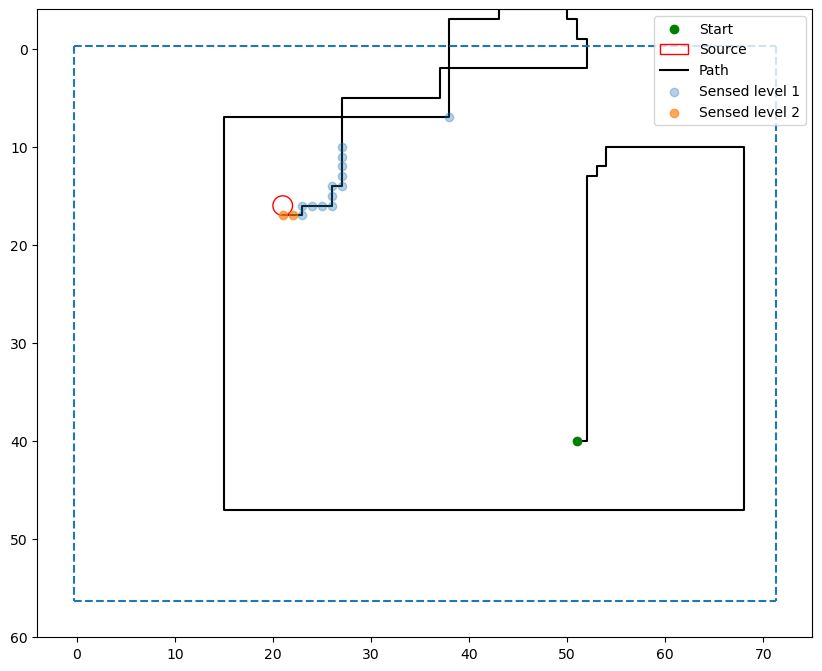

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = new_order_exp_agent_indices,
                        exp_source = new_order_exp_source_indices,
                        t_size = tank_size,
                        traj = 40,
                        ax = ax)

In [39]:
# Save all trajectories to folder
if not os.path.isdir(test_result_folder + 'trajectories/'):
    os.mkdir(test_result_folder + 'trajectories/')

out_of_traj_append = ['', '-in_05perc_marg', '-in_10perc_marg', '-in_25perc_marg', '-out_25perc_marg']

for i in range(len(new_order_exp_agent_indices)):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_trajectory_in_tank(h = all_hist,
                            exp_agent = new_order_exp_agent_indices,
                            exp_source = new_order_exp_source_indices,
                            t_size = tank_size,
                            traj = i,
                            ax = ax)

    plt.savefig(test_result_folder + 'trajectories/' + f'run-{i}{out_of_traj_append[out_of_bounds_amount[i]]}.png')
    plt.close(fig)

## Plots

In [40]:
a_df = all_hist.analysis_df
runs_df = a_df[[str(i).startswith('run_') for i in a_df.index]]
run_is_success = ~runs_df['reached_horizon'].astype(bool)
success_runs_df = runs_df.loc[run_is_success]

In [41]:
plot_folders = ['plots_in_0perc_marg/', 'plots_in_5perc_marg/', 'plots_in_10perc_marg/', 'plots_in_25perc_marg/', 'plots_all/']

# Create folders for plots
for folder in plot_folders:
    if not os.path.isdir(test_result_folder + folder):
        os.mkdir(test_result_folder + folder)

### Time taken plots

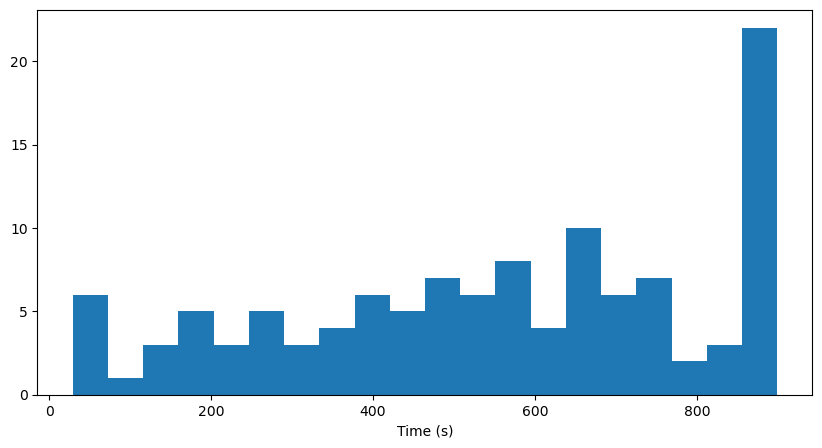

In [42]:
ax = (runs_df['steps_taken'] * step_dt).hist(grid=False, bins=20, figsize=(10,5))
ax.set_xlabel('Time (s)')
plt.show()

In [43]:
# Saving the plots
for i, folder in enumerate(plot_folders):
    filtered_runs_df = runs_df[out_of_bounds_amount <= i]
    ax = (filtered_runs_df['steps_taken'] * step_dt).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Time (s)')
    plt.savefig(test_result_folder + folder + 'time_taken.png')
    plt.close()

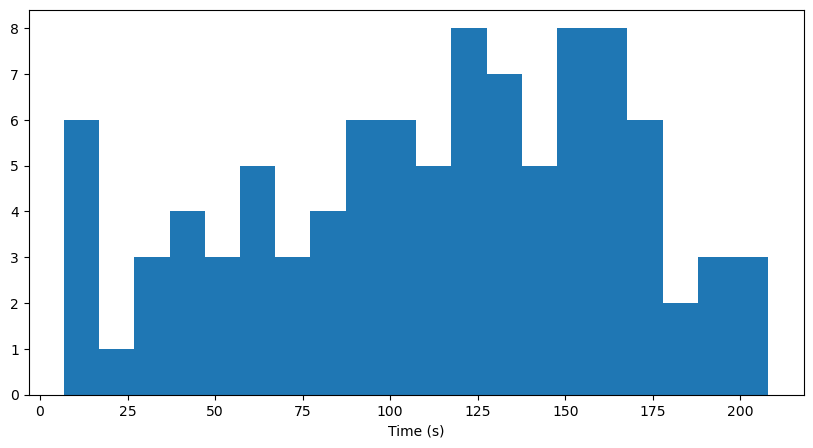

In [44]:
# Success only!
ax = (success_runs_df['steps_taken'] * dt).hist(grid=False, bins=20, figsize=(10,5))
ax.set_xlabel('Time (s)')
plt.show()

In [45]:
# Saving the plots
for i, folder in enumerate(plot_folders):
    filtered_success_runs_df = success_runs_df[(out_of_bounds_amount <= i)[run_is_success]]
    ax = (filtered_success_runs_df['steps_taken'] * step_dt).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Time (s)')
    plt.savefig(test_result_folder + folder + 'time_taken_success_only.png')
    plt.close()

### Distance plots

In [46]:
# Saving the plots
# Division by 100 to convert to meters
for i, folder in enumerate(plot_folders):
    filtered_runs_df = runs_df[out_of_bounds_amount <= i]
    ax = ((filtered_runs_df['steps_taken'] * step_dist) / 100).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Distance (m)')
    plt.savefig(test_result_folder + folder + 'distance.png')
    plt.close()

In [47]:
# Saving the plots
# Division by 100 to convert to meters
for i, folder in enumerate(plot_folders):
    filtered_success_runs_df = success_runs_df[(out_of_bounds_amount <= i)[run_is_success]]
    ax = ((filtered_success_runs_df['steps_taken'] * step_dist) / 100).hist(grid=False, bins=20, figsize=(10,5))
    ax.set_xlabel('Distance (m)')
    plt.savefig(test_result_folder + folder + 'distance_success_only.png')
    plt.close()

## Grid plots

In [48]:
all_success_array = []
all_speed_array = []
all_speed_success_array = []
all_count_array = []
all_count_success_array = []

for i, folder in enumerate(plot_folders):
    filtered_runs_df = runs_df[out_of_bounds_amount <= i]
    filtered_success_runs_df = success_runs_df[(out_of_bounds_amount <= i)[run_is_success]]

    # Retrieving successes and speed from dataframe
    successes = np.array(filtered_runs_df['converged'])
    speed = np.array(filtered_runs_df['steps_taken'])
    speed_success = np.array(filtered_success_runs_df['steps_taken'])

    # Compute the grid to use
    point_array = new_order_exp_source_indices[out_of_bounds_amount <= i] # exp_agent_indices or exp_source_indices

    grid = np.array([5,8])
    cell_indices = np.array(list(np.ndindex(tuple(grid))))
    cell_sizes = tank_size / grid

    point_cell = (point_array / cell_sizes).astype(int)

    # Compute successes and speeds in the grid
    success_array = np.zeros(grid, dtype=float)
    speed_array = np.zeros(grid, dtype=float)
    speed_success_array = np.zeros(grid, dtype=float)
    count_array = np.zeros(grid, dtype=int)
    count_success_array = np.zeros(grid, dtype=int)

    for cell in cell_indices:
        point_in_cell = np.all(point_cell == cell, axis=1)
        count_in_cell = np.sum(point_in_cell)
        count_array[*cell] = count_in_cell
        if count_in_cell == 0:
            continue

        success_perc = np.mean(successes[point_in_cell])
        average_speed = np.mean(speed[point_in_cell])

        success_array[*cell] = success_perc
        speed_array[*cell] = average_speed

        count_in_cell_success = np.sum(point_in_cell[run_is_success[out_of_bounds_amount <= i]])
        count_success_array[*cell] = count_in_cell_success
        if count_in_cell_success == 0:
            continue

        average_speed_success = np.mean(speed_success[point_in_cell[run_is_success[out_of_bounds_amount <= i]]])
        speed_success_array[*cell] = average_speed_success

    all_success_array.append(success_array)
    all_speed_array.append(speed_array)
    all_speed_success_array.append(speed_success_array)
    all_count_array.append(count_array)
    all_count_success_array.append(count_success_array)

### Convergence plot

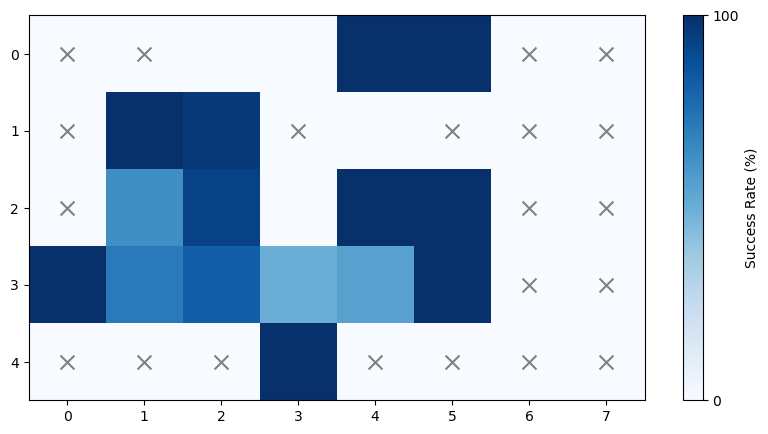

In [49]:
plt.figure(figsize=(10,5))

plt.imshow(all_success_array[-1] * 100, cmap='Blues', vmin=0, vmax=100)
cbar = plt.colorbar(ticks=[0,100])
cbar.set_label('Success Rate (%)')

no_sim = np.argwhere(all_count_array[-1] == 0)
plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

plt.show()

In [50]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    plt.imshow(all_success_array[i] * 100, cmap='Blues', vmin=0, vmax=100)
    cbar = plt.colorbar(ticks=[0,100])
    cbar.set_label('Success Rate (%)')

    no_sim = np.argwhere(all_count_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_success_rate.png')
    plt.close()

### Time Taken plots

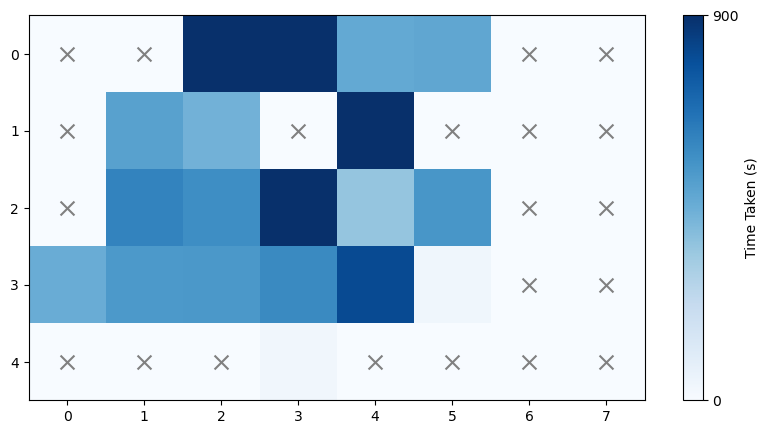

In [51]:
plt.figure(figsize=(10,5))

upper_bound = (np.ceil(np.max(all_speed_array[-1] * step_dt) / 100) * 100).astype(int)
plt.imshow(all_speed_array[-1] * step_dt, cmap='Blues', vmin=0, vmax=upper_bound)
cbar = plt.colorbar(ticks=[0,upper_bound])
cbar.set_label('Time Taken (s)')

no_sim = np.argwhere(all_count_array[-1] == 0)
plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

plt.show()

In [52]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_array[i] * step_dt) / 100) * 100).astype(int)
    plt.imshow(all_speed_array[i] * step_dt, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Time Taken (s)')

    no_sim = np.argwhere(all_count_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_time_taken.png')
    plt.close()

In [53]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_success_array[i] * step_dt) / 100) * 100).astype(int)
    plt.imshow(all_speed_success_array[i] * step_dt, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Time Taken (s)')

    no_sim = np.argwhere(all_count_success_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_time_taken_success_only.png')
    plt.close()

### Distance plots

In [54]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_array[i] * step_dist) / 100)).astype(int)
    plt.imshow((all_speed_array[i] * step_dist) / 100, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Distance (m)')

    no_sim = np.argwhere(all_count_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_distance.png')
    plt.close()

In [55]:
for i, folder in enumerate(plot_folders):
    plt.figure(figsize=(10,5))

    upper_bound = (np.ceil(np.max(all_speed_success_array[i] * step_dist) / 100)).astype(int)
    plt.imshow((all_speed_success_array[i] * step_dist) / 100, cmap='Blues', vmin=0, vmax=upper_bound)
    cbar = plt.colorbar(ticks=[0,upper_bound])
    cbar.set_label('Distance (m)')

    no_sim = np.argwhere(all_count_success_array[i] == 0)
    plt.scatter(no_sim[:,1], no_sim[:,0], c='grey', marker='x', s=100, label='No Simulations')

    plt.savefig(test_result_folder + folder + 'grid_distance_success_only.png')
    plt.close()

## Results

In [56]:
import os
import re

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

### Plots Results

In [ ]:
folder = test_result_folder

plot_sets = [
    'No filter',
    'Filtered all exitting',
    'Filtered all out of 5% margin',
    'Filtered all out of 10% margin',
    'Filtered all out of 25% margin'
]

# Create pdf folder
if not os.path.isdir(folder + 'results_pdfs/'):
    os.mkdir(folder + 'results_pdfs/')

for i, plot_folder_name in enumerate(['plots_all', 'plots_in_0perc_marg', 'plots_in_5perc_marg', 'plots_in_10perc_marg', 'plots_in_25perc_marg']):
    plot_folder = folder + plot_folder_name + '/'

    # Extracting the threshold level from the folder name
    thresh_level = int(folder.split('thresh_')[1].split('-')[0].split('e')[1])

    # Basic setup
    pdf_file_name = folder + 'results_pdfs/' + 'results_' + plot_folder_name + '.pdf'
    c = canvas.Canvas(pdf_file_name, pagesize=A4)
    width, height = A4
    margin = 10

    # List of png files in the specified order
    png_files = ['grid_success_rate', 'time_taken', 'grid_time_taken', 'distance', 'grid_distance']
    png_files = [os.path.join(plot_folder, f'{name}.png') for name in png_files]

    x_left = margin
    x_right = width / 2 + margin
    y = height - margin

    # Set title
    c.setFont("Helvetica-Bold", 18)
    c.drawString(x_left, y - 15, f"Results - Threshold: 3e-{thresh_level} - {plot_sets[i]}")
    y -= 20

    for png_file in png_files:
        if '/time_taken.png' in png_file:
            c.setFont("Helvetica-Bold", 12)
            c.drawString(x_left + margin, y - 15, "Speed of the agent (seconds)")
            y -= 20

        if '/distance.png' in png_file:
            c.setFont("Helvetica-Bold", 12)
            c.drawString(x_left + margin, y - 15, "Distance travelled by the agent (meters)")
            y -= 20

        img = Image.open(png_file)
        img_width, img_height = img.size

        # Resize the image to fit the PDF page
        aspect = img_width / img_height
        if aspect > 1:
            img_width = (width / 2) - (2 * margin)
            img_height = img_width / aspect
        else:
            img_height = (height / 2) - (2 * margin)
            img_width = img_height * aspect

        if y - img_height < margin:
            c.showPage()
            y = height - margin

        c.drawImage(png_file, x_left, y - img_height, img_width, img_height)
        if 'grid_success_rate' in png_file: # Add the plume image
            img = Image.open(folder + 'plume.png')
            plume_img_width, plume_img_height = img.size
            plume_img_width = min(plume_img_width, img_width)
            plume_img_height = min(plume_img_height, img_height)

            # Resize the image to fit the PDF page
            aspect = plume_img_width / plume_img_height
            if aspect > 1:
                plume_img_width = (width / 2) - (2 * margin)
                plume_img_height = plume_img_width / aspect
            else:
                plume_img_height = (height / 2) - (2 * margin)
                plume_img_width = plume_img_height * aspect

            c.drawImage(folder + 'plume.png', x_right, y - img_height, plume_img_width, plume_img_height)
        else: # Plotting _success_only versions of the plots except for the success_rate
            c.drawImage(png_file.replace('.png', '_success_only.png'), x_right, y - img_height, img_width, img_height)
        y -= img_height + margin

    c.save()
    print(f"PDF saved as {pdf_file_name}")

PDF saved as ./results-thresh_3e5-20250110_135618/results_pdfs/results_plots_all.pdf
PDF saved as ./results-thresh_3e5-20250110_135618/results_pdfs/results_plots_in_0perc_marg.pdf
PDF saved as ./results-thresh_3e5-20250110_135618/results_pdfs/results_plots_in_5perc_marg.pdf
PDF saved as ./results-thresh_3e5-20250110_135618/results_pdfs/results_plots_in_10perc_marg.pdf
PDF saved as ./results-thresh_3e5-20250110_135618/results_pdfs/results_plots_in_25perc_marg.pdf


### Trajectories

In [58]:
folder = test_result_folder

# Define the folder containing the trajectory images
trajectory_folder = os.path.join(folder, 'trajectories')

# Get the list of trajectory PNG files
trajectory_files = [f for f in os.listdir(trajectory_folder) if f.endswith('.png')]

# Sort the files by the number in the filename
trajectory_files.sort(key=lambda x: int(re.search(r'run-(\d+)', x).group(1)))

# Create a new PDF file for the trajectories
trajectory_pdf_file_name = os.path.join(folder + 'results_pdfs/', 'trajectories.pdf')
c = canvas.Canvas(trajectory_pdf_file_name, pagesize=A4)
width, height = A4
margin = 5

# Set the number of columns
num_columns = 4
column_width = (width - (num_columns + 1) * margin) / num_columns

# Initialize the position
x = margin
y = height - margin

for i, trajectory_file in enumerate(trajectory_files):
    # Open the image
    img = Image.open(os.path.join(trajectory_folder, trajectory_file))
    img_width, img_height = img.size

    # Resize the image to fit the column width
    aspect = img_width / img_height
    img_width = column_width
    img_height = img_width / aspect

    # Check if we need to move to the next row
    if x + img_width + margin > width:
        x = margin
        y -= img_height + 2 * margin + 15  # 15 for the text height

    # Check if we need to add a new page
    if y - img_height < margin:
        c.showPage()
        x = margin
        y = height - margin

    # Draw the file name above the image
    c.setFont("Helvetica", 8)
    c.drawString(x, y - 13, trajectory_file.removesuffix('.png'))

    # Draw the image
    c.drawImage(os.path.join(trajectory_folder, trajectory_file), x, y - img_height - 15, img_width, img_height)

    # Move to the next column
    x += img_width + margin

# Save the PDF
c.save()
print(f"Trajectory PDF saved as {trajectory_pdf_file_name}")

Trajectory PDF saved as ./results-thresh_3e5-20250110_135618/results_pdfs/trajectories.pdf
